If you plan on using this implementation, please cite our work:

@INPROCEEDINGS{Grabowski2021IGARSS,
author={Grabowski, Bartosz and Ziaja, Maciej and Kawulok, Michal
and Nalepa, Jakub},
booktitle={IGARSS 2021 - 2021 IEEE International Geoscience
and Remote Sensing Symposium},
title={Towards Robust Cloud Detection in
Satellite Images Using U-Nets},
year={2021},
note={in press}}

# Demo of the cloud detection using thresholding algorithm on panchromatic data
This document presents the cloud detection on example Landsat 8 panchromatic images using thresholding algorithm. The full script can be found in cloud_detection/scripts/panchromatic_thresholding.py.

The algorithm works in the following way:


- The threshold 0 &le; T &le; 1 as well as an input image X are set.
- The minimum (min_X) and maximum (max_X) values of the pixels are extracted from the image X (please note that for panchromatic data, all pixels have only one value). The border, black pixels are excluded from this operation.
- The image threshold T_X is calculated using the following formula: T_X = min_X + (max_X - min_X) * T
- The image threshold T_X is used to classify the pixels. More specifically, all pixels with value greater or equal to T_X are classified as clouds. The rest is classified as non-clouds.

First, we import neccessary libraries.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
from pathlib import Path
from collections import defaultdict
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from tensorflow.keras.metrics import binary_crossentropy, binary_accuracy

from cloud_detection.scripts.panchromatic_thresholding import ThresholdingClassifier
from cloud_detection import losses
from cloud_detection.utils import (
    open_as_array, load_l8cca_gt, get_metrics_tf
)

Next, we set the parameters for the experiment.
These parameters are the following:


- dpath - path to the dataset.
- rpath - path to directory where results should be stored.
- eval_imgs - types and IDs of images to evaluate.
- thresholds - threshold values to perform panchromatic thresholding.
- metric_fns - non-Tensorflow metric functions to run evaluation of the thresholding. It must be of the form func(labels_true, labels_pred).
- tf_metric_fns - TensorFlow metric functions to run evaluation of the thresholding. It must be of the form func(labels_true, labels_pred).
- band_num - band to load (in this case, panchromatic band is loaded).
- band_name - name of the band to load.
- normalize - whether to normalize the data.
- standardize - whether to standardize the data.

In [2]:
dpath = Path("datasets/clouds/Landsat-Cloud-Cover-Assessment-Validation-Data-Partial")
rpath = Path("artifacts/cloud_thresholding_demo/")
eval_imgs = [["Water", "LC82150712013152LGN00"],
             ["Snow-ice", "LC81321192014054LGN00"]]
thresholds = [0.1, 0.5]
metric_fns = [normalized_mutual_info_score,
              adjusted_rand_score]
tf_metric_fns = [losses.JaccardIndexLoss(),
                 losses.JaccardIndexMetric(),
                 losses.DiceCoefMetric(),
                 losses.recall,
                 losses.precision,
                 losses.specificity,
                 binary_crossentropy,
                 binary_accuracy]
band_num = 8
band_name = "panchromatic"
normalize = False
standardize = False

We define the function to load the image as well as its ground truth.

In [3]:
def load_data(img_path, band_name, band_num, normalize, standardize):
    # Load gt
    gt = load_l8cca_gt(img_path)
    # Load img
    channel_files = {}
    channel_files[band_name] = list(
        img_path.glob(f"*_B{band_num}.TIF"))[0]
    img = open_as_array(
        channel_files=channel_files,
        channel_names=(band_name,),
        size=gt.shape,
        normalize=normalize,
        standardize=standardize,
        )
    return img, gt

Next, we define the function to get thresholding algorithm prediction given threshold value and image.

In [4]:
def get_thr_pred(thr, img):
    # Create & fit classifier
    thr_classifier = ThresholdingClassifier(thr_prop=thr).fit(img)
    # Predict cloud mask
    mask = thr_classifier.predict(img)
    return mask

We define the function to calculate desired metrics given ground truth and the cloud mask predicted by the algorithm.

In [5]:
def get_metrics(gt, mask, tf_metric_fns, metric_fns, metrics_aggr):
    metrics = get_metrics_tf(gt, mask, tf_metric_fns)
    for metric_fn in metric_fns:
        metrics[f"{metric_fn.__name__}"] = metric_fn(
            gt.reshape(-1),
            mask.reshape(-1)
        )
    print(metrics)
    for k, v in metrics.items():
        metrics_aggr[k].append(v)
    return metrics_aggr

Lastly, we define the function to make visualisations of the results, and then save them to rpath dir.

In [6]:
def make_vis(img_type, img_name, gt, mask, rpath, thr):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
    fig.suptitle(f"{img_type}-{img_name}")
    axs[0].imshow(gt[:, :, 0])
    axs[0].set_title("GT")
    axs[1].imshow(mask[:, :, 0])
    axs[1].set_title("pred")
    fig.savefig(
        rpath / f"thr_{int(thr*100)}" /
        f"{img_type}-{img_name}.png")
    plt.close(fig)

The full pipeline as well as the output can be seen below.

In [7]:
rpath.mkdir(parents=True, exist_ok=False)
img_paths = [dpath / id_[0] / id_[1] for id_ in eval_imgs]
for thr in thresholds:
    print("THRESHOLD:", thr)
    (rpath / f"thr_{int(thr*100)}").mkdir(
        exist_ok=False, parents=True
    )
    metrics_aggr = defaultdict(list)
    for img_path in img_paths:
        img_type, img_name = img_path.parent.name, img_path.name
        print(img_type, img_name)
        img, gt = load_data(img_path, band_name, band_num,
                            normalize, standardize)
        mask = get_thr_pred(thr, img)
        metrics_aggr = get_metrics(gt, mask, tf_metric_fns,
                                   metric_fns, metrics_aggr)
        make_vis(img_type, img_name, gt, mask, rpath, thr)
    metrics_mean = {}
    for k, v in metrics_aggr.items():
        metrics_mean[k] = np.mean(v)
    print("Mean metrics")
    print(metrics_mean)
    print("")

THRESHOLD: 0.1
Water LC82150712013152LGN00
{'jaccard_index_loss': 0.1802644, 'jaccard_index_metric': 0.8197357, 'dice_coeff_metric': 0.8962242, 'recall': 0.8337768, 'precision': 0.99521667, 'specificity': 0.99814063, 'binary_crossentropy': 0.86546046, 'binary_accuracy': 0.9460512, 'normalized_mutual_info_score': 0.7096062523934302, 'adjusted_rand_score': 0.7896431784010113}
Snow-ice LC81321192014054LGN00
{'jaccard_index_loss': 0.7884275, 'jaccard_index_metric': 0.21157268, 'dice_coeff_metric': 0.3369484, 'recall': 1.0, 'precision': 0.20104995, 'specificity': 0.108434066, 'binary_crossentropy': 11.650334, 'binary_accuracy': 0.2718083, 'normalized_mutual_info_score': 0.04866410820201292, 'adjusted_rand_score': -0.08714989509556287}
Mean metrics
{'jaccard_index_loss': 0.48434594, 'jaccard_index_metric': 0.5156542, 'dice_coeff_metric': 0.6165863, 'recall': 0.91688836, 'precision': 0.5981333, 'specificity': 0.5532873, 'binary_crossentropy': 6.2578974, 'binary_accuracy': 0.60892975, 'normali

The generated images are displayed below.

THRESHOLD: 0.1


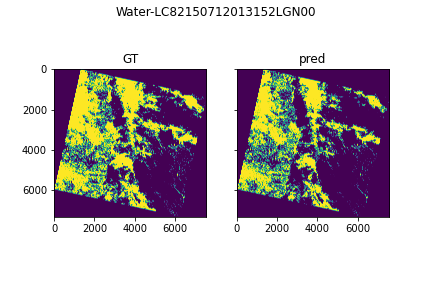

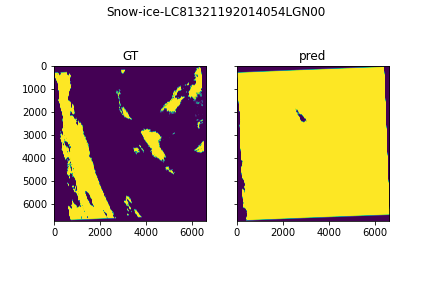

THRESHOLD: 0.5


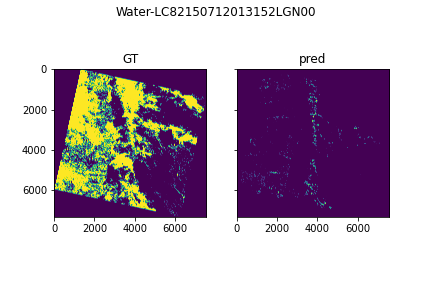

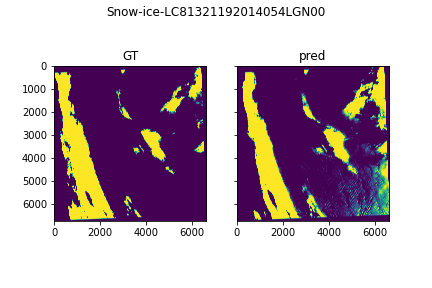

In [8]:
for thr in thresholds:
    print("THRESHOLD:", thr)
    for img_type, img_name in eval_imgs:
        display(Image.open(rpath / f"thr_{int(thr*100)}" / f"{img_type}-{img_name}.png", "r"))